<a href="https://colab.research.google.com/github/Uz8351/MyPhython/blob/master/Copia_de_ParaAprenderAula_888.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

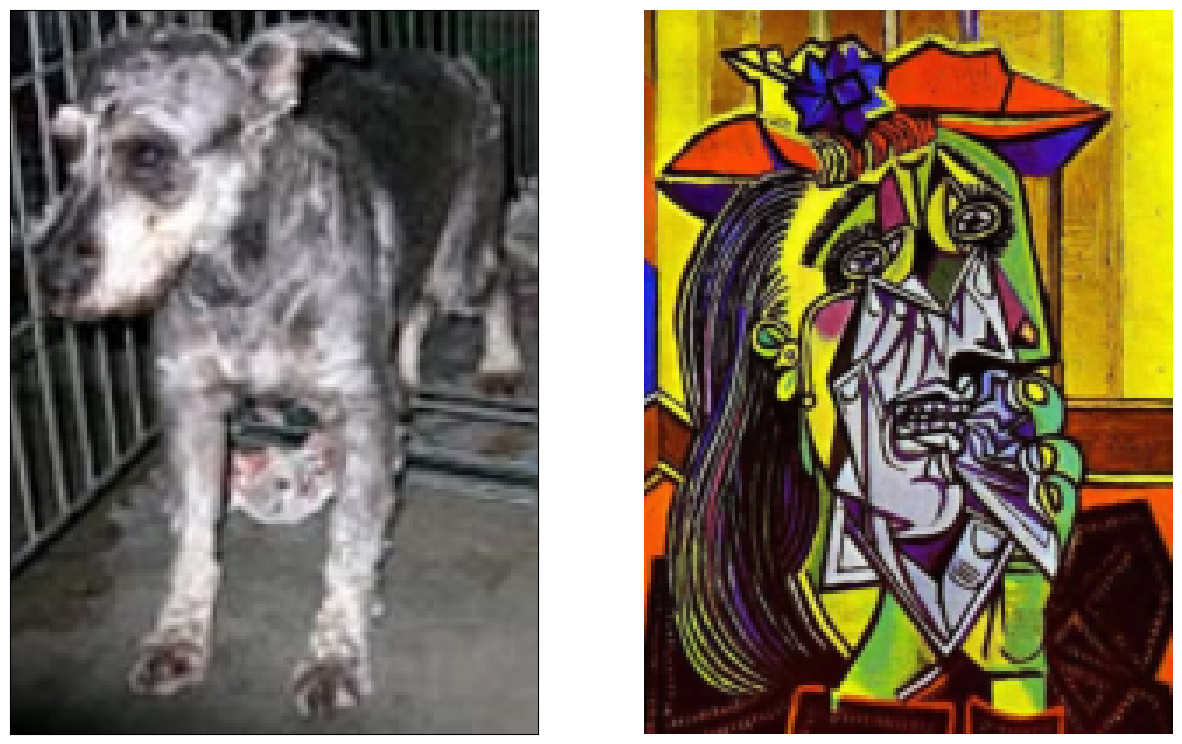

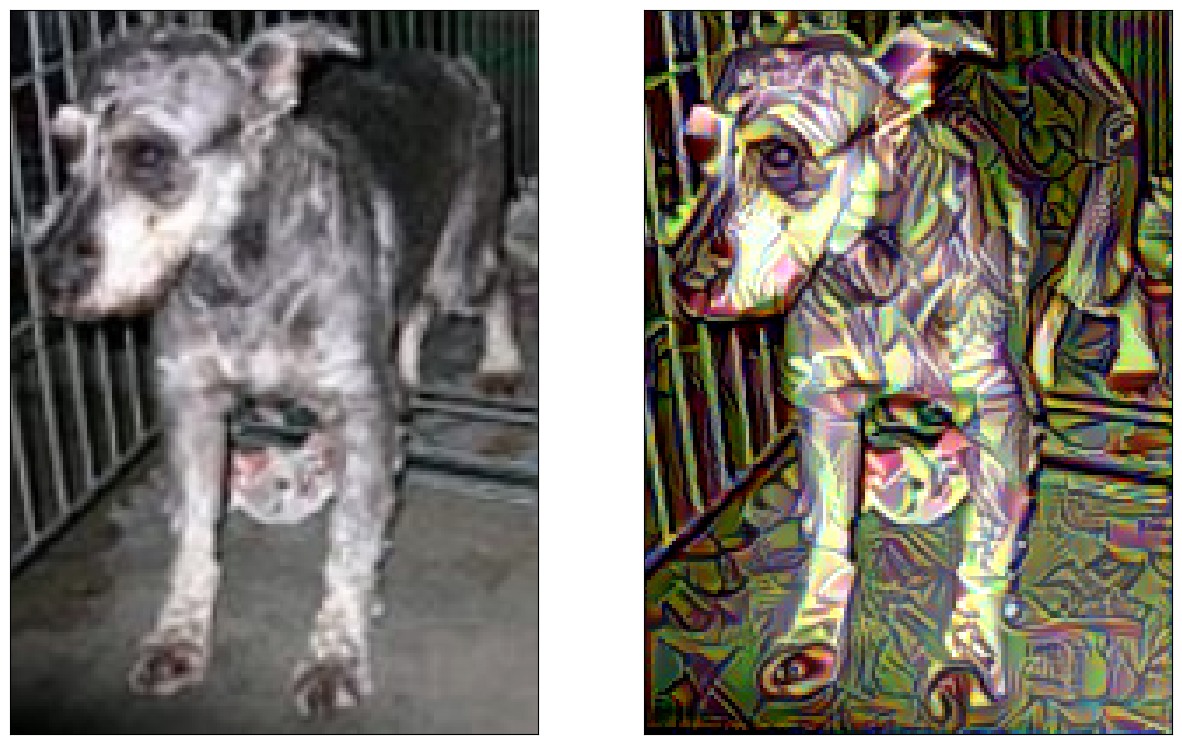

In [4]:
# importando los recursos
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

# obtiene la porción "features" de VGG19
vgg = models.vgg19(pretrained=True).features

# congelamos todos los parámetros VGG dado que solo estamos optimizando la imagen objetivo
for param in vgg.parameters():
    param.requires_grad_(False)
# mover el modelo a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')

    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406),
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)

    return image
# cargando las imágenes content y style
content = load_image('/content/drive/MyDrive/druida/Dog/10001.jpg').to(device)
# Redimensionar style para emparejar al content, hace más facil el trabajo
style = load_image('/content/drive/MyDrive/druida/picaso.jpg', shape=content.shape[-2:]).to(device)
# función para desnormalizar una imagen
# y convertirla de una imagen Tensor a una imagen NumPy para su visualización
def im_convert(tensor):
    """ Muestra un tensor como una imagen. """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image
# muestra la imagen
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
# content y style lado a lado
plt.axis('off')

ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
ax1.imshow(im_convert(content))

ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax2.imshow(im_convert(style))
def get_features(image, model, layers=None):
    """ Correr una imagen hacia adelante a través de un modelo y obtener las características para
        un conjunto de capas. Las capas predeterminadas son para VGGNet que coincida con Gatys et al (2016)
    """

    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1',
                  '35': 'conv6_1'}
    features = {}
    x = image
    # model._modules es un diccionario que contiene cada módule en el modelo
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features
def gram_matrix(tensor):


    # obtiene el batch_size, profundidad, alto y ancho del Tensor
    _, d, h, w = tensor.size()

    # redimensiona para poder multiplicar los features para cada canal
    tensor = tensor.view(d, h * w)

    # calcula la gram matrix
    gram = torch.mm(tensor, tensor.t())

    return gram
# obtiene los features de content y style features  una sola vez antes de entrenar
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calcula las matrices Gram para cada capa de nuestra representación de estilo
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# crea una tercera imagen, nuestra imagen objetivo/target, y la prepara para que cambie

target = content.clone().requires_grad_(True).to(device)
# weights para cada capa de estilo
# note que excluimos `conv4_2` de nuestra representación de contenido
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta
#content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
# cada cuantos pasos se mostrará un avance
show_every = 250

# hyperparametros de iteración
optimizer = optim.Adam([target], lr=0.03)
steps = 100  # cuantas iteraciónes tomará la imagen

for ii in range(1, steps+1):

    # obtiene los features de la imagen objetivo/target
    target_features = get_features(target, vgg)

    # la perdida de contenido
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # la perdida de estilo
    # inicializa en 0
    style_loss = 0
    # luego se suma cada pérdida de capa de matriz Gram
    for layer in style_weights:
        # obtiene la representación de estilo de la imagen objetivo para la capa
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # obtiene la representación de estilo
        style_gram = style_grams[layer]
        # la pérdida de estilo para una capa multiplicada por su beta
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # suma las pérdidas de estilo
        style_loss += layer_style_loss / (d * h * w)

    # calcula la pérdida total
    total_loss = content_weight * content_loss + style_weight * style_loss

    # actualiza la imagen objetivo
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # muestra las imágenes intermedias e imprime la pérdida y el número de iteración
    if  ii % show_every == 0:
        print('Pérdida total / Total loss: ', total_loss.item())
        print('Iteración # ', ii)
        plt.imshow(im_convert(target))
        plt.axis('off')
        plt.show()
# Muestra la imagen original (content) y la imagen final (target)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
ax1.imshow(im_convert(content))

ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax2.imshow(im_convert(target))
